## Statistics 504 Homework #2 <br>
DRAFT 1.0 <br>
Fall 2015 <br>
Erich Seamon <br>
University of Idaho <br>
erichs@uidaho.edu <br>
http://github.com/erichseamon.com/stat504-python <br>

This assignment uses a small subset of the data from Kaggle's Yelp Business Rating Prediction competition. The data set is at https://github.com/justmarkham/DAT7/tree/master/data/yelp.csv
Description of the data: Each observation in this dataset is a review of a particular business by a particular user. The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) The "cool" column is the number of "cool" votes this particular review received from other Yelp users. There is no limit to how many "cool" votes a review can receive. The "useful" and "funny" columns are similar to the "cool" column.


#### TASK 1: read yelp.csv into a DataFrame

In [218]:
import matplotlib
%matplotlib nbagg

import pandas as pd
import numpy as np
import random
#random.seed(1234567) #setting the random seed for reproducible results consistent across our class - fall 2015
yelp = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT7/master/data/yelp.csv')

#### TASK 2: create a new DataFrame that only contains the 5-star and 1-star reviews.

In [124]:
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

#### TASK 3: Use a random seed 1234567, split the new DataFrame into training and testing sets

In [125]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yelp_best_worst.text, yelp_best_worst.stars, random_state=1234567)

#### TASK 4: use CountVectorizer to create document-term matrices from X_train and X_test

In [126]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)



In [128]:
vect2 = CountVectorizer()
X = vect2.fit_transform(yelp_best_worst.text)
y = yelp_best_worst.stars

#### TASK 5a: use Logistic Regression to predict the star rating for the testing set, and calculate accuracy

In [129]:
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_dtm, y_train)
y_pred_class = logreg.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.936399217221


#### TASK 5b: use K-Nearest Neighbors to predict the star rating for the testing set, and calculate accuracy

In [130]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=25)
neigh.fit(train_dtm, y_train)
y_pred_class = neigh.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.8228962818


###### Calculate TRAINING ERROR and TESTING ERROR for K=1 through 50 for K-Nearest Neighbors

In [131]:
# calculate TRAINING ERROR and TESTING ERROR for K=1 through 50
k_range = range(1, 50)
training_error = []
testing_error = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # training error
    knn.fit(X, y)
    y_pred = knn.predict(X)
    training_error.append(1 - metrics.accuracy_score(y, y_pred))
    # testing error
    knn.fit(train_dtm, y_train)
    y_pred = knn.predict(test_dtm)
    testing_error.append(1 - metrics.accuracy_score(y_test, y_pred))

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Plot the relationship between K (HIGH TO LOW) and TESTING ERROR

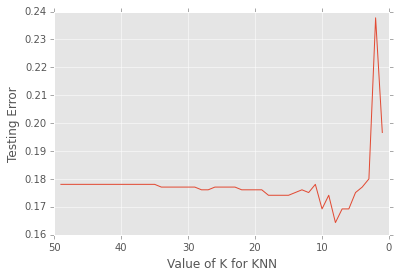

In [133]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
plt.plot(k_range, testing_error)
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Error')

In [134]:
df = pd.DataFrame({'K': k_range, 'train':training_error, 'test':testing_error}).set_index('K').sort_index(ascending=False)

#### Plot both test and train datasets for k and test error

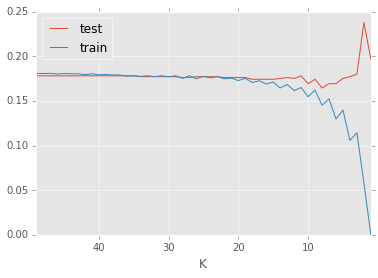

In [135]:
df.plot()

#### TASK 5c: use Classification Tree to predict the star rating for the testing set, and calculate accuracy

In [136]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(train_dtm, y_train)
y_pred_class = clf.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.85518590998


In [137]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

In [138]:
graph.write_jpeg("yelp_tree_plot.jpg")

True

In [139]:
from IPython.display import Image
Image(filename='yelp_tree_plot.jpg')

### Calculate AUC and ROC for all three models

#### TASK 6a: calculate the logistic regression AUC

In [140]:
# TASK 6: calculate the logistic regression AUC
log_y_pred_prob = logreg.predict_proba(test_dtm)[:, 1]
import numpy as np
log_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(log_y_test_binary, log_y_pred_prob)

0.962367377245


#### TASK 6b: calculate the k nearest neighbors AUC

In [141]:
# TASK 6: calculate the k nearest neighbors AUC
knn_y_pred_prob = neigh.predict_proba(test_dtm)[:, 1]
import numpy as np
knn_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(knn_y_test_binary, knn_y_pred_prob)

0.785058324703


#### TASK 6c: calculate the classification tree AUC

In [142]:
# TASK 6: calculate the k nearest neighbors AUC
tree_y_pred_prob = clf.predict_proba(test_dtm)[:, 1]
import numpy as np
tree_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(tree_y_test_binary, tree_y_pred_prob)

0.740896331178


#### TASK 7: plot the ROC curves for all three models

<IPython.core.display.Javascript object>


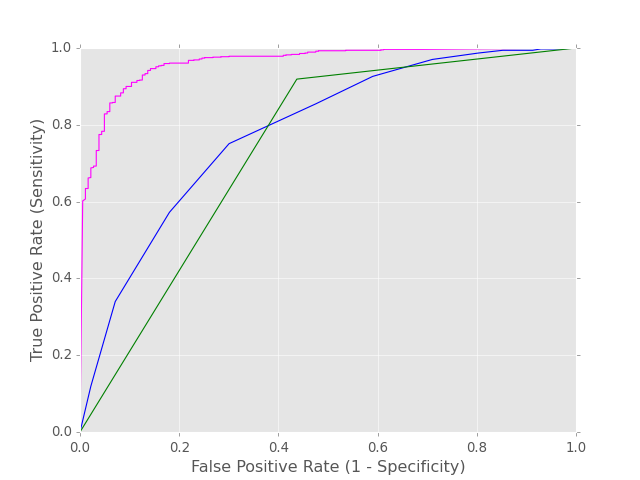

In [152]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg

import matplotlib.pyplot as plt
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(knn_y_test_binary, knn_y_pred_prob)
plt.plot(knn_fpr, knn_tpr, color='blue')

log_fpr, log_tpr, thresholds = metrics.roc_curve(log_y_test_binary, log_y_pred_prob)
plt.plot(log_fpr, log_tpr, color='magenta')

tree_fpr, tree_tpr, thresholds = metrics.roc_curve(tree_y_test_binary, tree_y_pred_prob)
plt.plot(tree_fpr, tree_tpr, color='green')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

### Task 9: Add additional features and re-run all three models - AUC and ROC curves

In [144]:
train_dtm

<3064x16726 sparse matrix of type '<type 'numpy.int64'>'
	with 236658 stored elements in Compressed Sparse Row format>

In [145]:
categories = ['alt.atheism', 'talk.religion.misc']

In [146]:
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_dtm, y_train)
y_pred_class = logreg.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.936399217221


### TASK 6: Add vote types (cool/useful/funny) as an additional features into the modeling process and refit the three models to predict the star rating in the testing set, and calculate the AUC and plot the ROC Curve for the three models. Any improvement or not? Comment on your findings.

In [174]:
feature_cols = ['text', 'cool', 'useful', 'funny']
yelp_best_worst_featureadd = yelp_best_worst[feature_cols] #for use in Task 6

X_train, X_test, y_train, y_test = train_test_split(yelp_best_worst_featureadd, yelp_best_worst.stars, random_state=1234567)

In [175]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
train_dtm = vect.fit_transform(X_train.text)
test_dtm = vect.transform(X_test.text) 

PandasError: DataFrame constructor not properly called!

In [214]:
train_dtm2 = train_dtm.tocsc()[:,:1]
test_dtm2 = test_dtm.tocsc()[:,:1]

In [217]:
pd.DataFrame(train_dtm2)

PandasError: DataFrame constructor not properly called!

In [171]:
feature_cols = ['cool', 'useful', 'funny']
yelp_best_worst_featureadd = yelp_best_worst[feature_cols] #for use in Task 6

X_train, X_test, y_train, y_test = train_test_split(yelp_best_worst_featureadd, yelp_best_worst.stars, random_state=1234567)

In [172]:
pd.concat([train_dtm, yelp_best_worst_featureadd], axis=1)

TypeError: cannot concatenate a non-NDFrame object

In [149]:
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.834637964775


In [158]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(X_train, y_train)
y_pred_class = neigh.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.827788649706


In [159]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_class = clf.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.824853228963


#### Calculate AUC for newly fitted models using cool.useful.funny features

In [160]:
# TASK 6: calculate the logistic regression AUC
log_y_pred_prob = logreg.predict_proba(X_test)[:, 1]
import numpy as np
log_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(log_y_test_binary, log_y_pred_prob)

0.674433524167


In [161]:
# TASK 6: calculate the k nearest neighbors AUC
knn_y_pred_prob = neigh.predict_proba(X_test)[:, 1]
import numpy as np
knn_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(knn_y_test_binary, knn_y_pred_prob)

0.651455349525


In [162]:
# TASK 6: calculate the k nearest neighbors AUC
tree_y_pred_prob = clf.predict_proba(X_test)[:, 1]
import numpy as np
tree_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(tree_y_test_binary, tree_y_pred_prob)

0.620387919524


<IPython.core.display.Javascript object>


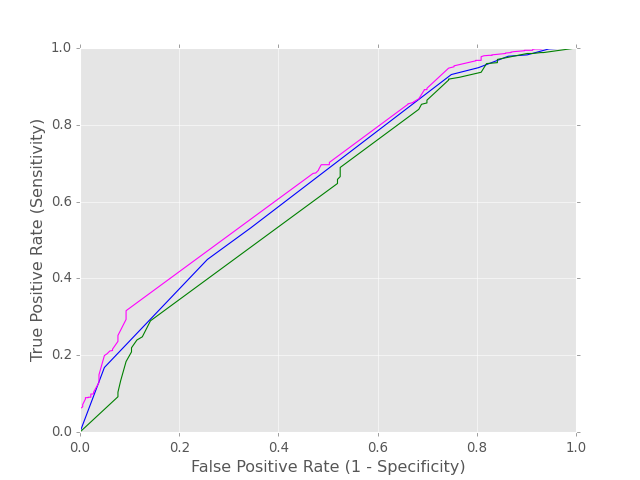

In [163]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg

import matplotlib.pyplot as plt
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(knn_y_test_binary, knn_y_pred_prob)
plt.plot(knn_fpr, knn_tpr, color='blue')

log_fpr, log_tpr, thresholds = metrics.roc_curve(log_y_test_binary, log_y_pred_prob)
plt.plot(log_fpr, log_tpr, color='magenta')

tree_fpr, tree_tpr, thresholds = metrics.roc_curve(tree_y_test_binary, tree_y_pred_prob)
plt.plot(tree_fpr, tree_tpr, color='green')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')